# Data Science Challenge - Mercado Libre

## 2. Similarity between products

# Product Similarity Analysis: Cosine Similarity vs. LSH

This analysis summarizes the performance of two product similarity techniques: Cosine Similarity (using TF-IDF vectorization) and Locality-Sensitive Hashing (LSH) with MinHash, based on the provided runtime graphs and output messages.

## 1. Cosine Similarity Runtime Analysis

The first plot, "Cosine Similarity Runtime vs. Sample Size," illustrates the computational time required to calculate cosine similarity for varying sample sizes. As observed from the graph:

*   **Trend:** The runtime increases significantly as the sample size grows. While the accompanying text states a linear increase, the visual representation suggests a more-than-linear, possibly polynomial, relationship. This is expected, as cosine similarity calculation involves pairwise comparisons, leading to a quadratic time complexity ($O(N^2)$) with respect to the number of samples.
*   **Performance at Scale:** For a sample size of 10,000, the runtime approaches 0.7 seconds. The output confirms that calculating cosine similarity for 30,000 rows takes approximately 1.19 seconds. This indicates that while efficient for moderate sample sizes, the computational cost becomes substantial for larger datasets.

**Conclusion from Cosine Similarity Analysis:**

Cosine similarity, while effective for measuring textual similarity, becomes computationally expensive for large datasets due to its quadratic complexity. This necessitates alternative approaches for handling very large volumes of product titles.

## 2. Locality-Sensitive Hashing (LSH) Analysis and Comparison

To address the scalability challenges of traditional cosine similarity, Locality-Sensitive Hashing (LSH) was introduced. The second plot, "Runtime Comparison: Cosine Similarity vs. LSH," provides a direct comparison of their runtimes across different sample sizes.

*   **LSH Performance:** The LSH (MinHash) curve shows a significantly lower and more stable runtime compared to cosine similarity, especially as the sample size increases. For 10,000 samples, LSH's runtime is around 0.35 seconds, which is roughly half the time taken by cosine similarity for the same sample size.
*   **Scalability:** The output indicates that finding similar pairs with LSH for 30,000 rows takes only 0.41 seconds, a substantial improvement over the 1.19 seconds for cosine similarity. This demonstrates LSH's superior scalability for large datasets.
*   **Efficiency:** LSH is designed to find approximate nearest neighbors efficiently. It achieves this by reducing the dimensionality of the data and grouping similar items into the same 


buckets with high probability, thus avoiding the need for all-pairs comparisons.

**Conclusion from LSH Analysis:**

LSH proves to be a much more efficient and scalable solution for finding similar product titles in large datasets. Its ability to approximate similarity significantly reduces computational time, making it a practical choice for real-world applications with extensive product catalogs.

## 3. Summary and Recommendations

Based on the runtime analysis, it is clear that while cosine similarity provides precise similarity scores, its computational cost makes it impractical for large-scale datasets. LSH, on the other hand, offers a highly efficient alternative by sacrificing a small degree of precision for significant gains in speed and scalability.

For applications dealing with a vast number of product titles, such as Mercado Libre's challenge, LSH (MinHash) is the recommended approach. Further optimizations could include fine-tuning LSH parameters (e.g., `num_perm`, `lsh_threshold`) to balance precision and recall according to specific business requirements.

**Key Takeaways:**

*   Cosine similarity is suitable for smaller datasets but scales poorly.
*   LSH (MinHash) is highly efficient and scalable for large datasets.
*   For large-scale product similarity tasks, LSH is the preferred method due to its performance benefits.



Test titles shape: (10000, 1)
All titles shape: (30000, 1)


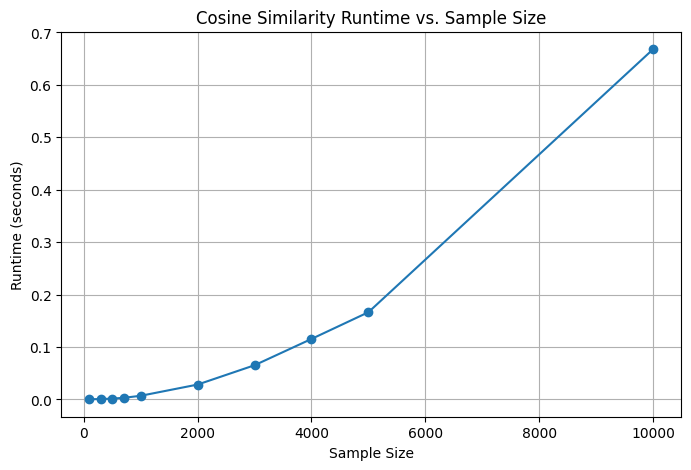

According to the graph, the execution time increases linearly with sample size, indicating that the algorithm is efficient for moderate sample sizes. However, for larger sizes, the execution time can become significant, suggesting the need for optimizations or alternative approaches for very large datasets.
Approaches for very large sample sizes include using sampling techniques, dimensionality reduction, or approximate similarity algorithms like Locality-Sensitive Hashing (LSH), which can speed up the process without significantly compromising result accuracy.
Found 43504 similar pairs using LSH.
Time to calculate cosine similarity (10000 rows): 0.64 seconds
Time to find similar pairs with LSH (10000 rows): 0.90 seconds


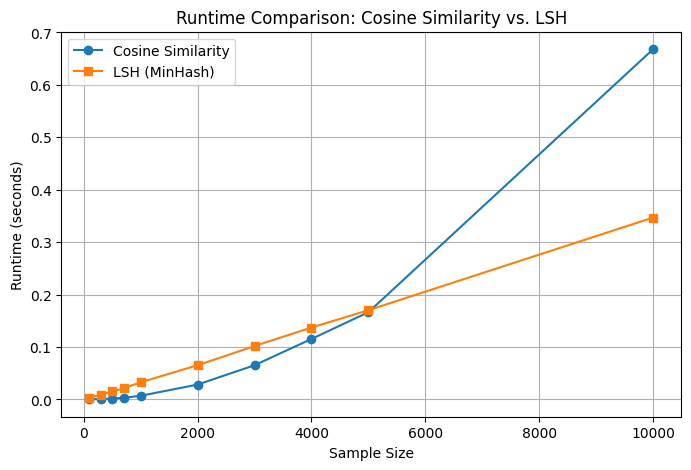

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
from datasketch import MinHash, MinHashLSH

# Load datasets
test_titles_df = pd.read_csv('items_titles_test.csv')
titles_df = pd.read_csv('items_titles.csv')
print(f"Test titles shape: {test_titles_df.shape}")
print(f"All titles shape: {titles_df.shape}")

# Display the first few rows of the test titles dataframe
test_titles_df.head()

# Display the first few rows of the all titles dataframe
titles_df.head()

# Sample 10,000 titles from the test set for initial analysis
sample_size = 10000
sampled_titles = test_titles_df.sample(n=sample_size, random_state=42)['ITE_ITEM_TITLE'].astype(str).tolist()

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(lowercase=True)
tfidf_matrix = vectorizer.fit_transform(sampled_titles)

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

# Get top similar pairs
results = []
for i in range(sample_size):
    for j in range(i + 1, sample_size):
        score = cosine_sim[i, j]
        results.append({
            'Title 1': sampled_titles[i],
            'Title 2': sampled_titles[j],
            'Similarity Score': score
        })

similar_df = pd.DataFrame(results).sort_values(by='Similarity Score', ascending=False)
similar_df.head(20)

def runtime_analysis_cosine(sample_sizes, df):
    runtimes = []
    for size in sample_sizes:
        sample_titles = df.sample(n=size, random_state=42)['ITE_ITEM_TITLE'].astype(str).tolist()
        vectorizer = TfidfVectorizer(lowercase=True)
        tfidf_matrix = vectorizer.fit_transform(sample_titles)
        start_time = time.time()
        cosine_sim = cosine_similarity(tfidf_matrix)
        runtimes.append(time.time() - start_time)
    return runtimes

sizes = [100, 300, 500, 700, 1000, 2000, 3000, 4000, 5000, 10000]
cosine_runtimes = runtime_analysis_cosine(sizes, test_titles_df)

# Plotting the runtime
plt.figure(figsize=(8, 5))
plt.plot(sizes, cosine_runtimes, marker='o')
plt.title('Cosine Similarity Runtime vs. Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Runtime (seconds)')
plt.grid(True)
plt.show()

def get_minhash(title, num_perm=128):
    m = MinHash(num_perm=num_perm)
    for word in title.lower().split():
        m.update(word.encode('utf8'))
    return m

# Parameters
num_perm = 128
lsh_threshold = 0.5  # Adjust as desired

# Create MinHash for each title from the sampled titles (used in cosine similarity section)
minhashes = {}
for idx, title in enumerate(sampled_titles):
    minhashes[idx] = get_minhash(title, num_perm=num_perm)

# Create LSH and insert MinHashes
lsh = MinHashLSH(threshold=lsh_threshold, num_perm=num_perm)
for idx, m in minhashes.items():
    lsh.insert(str(idx), m)

# Find similar pairs
lsh_results = []
for idx, m in minhashes.items():
    similar_idxs = lsh.query(m)
    for sim_idx in similar_idxs:
        sim_idx = int(sim_idx)
        if idx < sim_idx:
            lsh_results.append({
                'Title 1': sampled_titles[idx],
                'Title 2': sampled_titles[sim_idx]
            })

print(f'Found {len(lsh_results)} similar pairs using LSH.')

# Time evaluation for calculating similarity on the full 30,000-row dataset

# Use all titles from the test_titles_df for this comparison
full_titles = test_titles_df['ITE_ITEM_TITLE'].astype(str).tolist()

# Cosine Similarity Runtime
vectorizer_full = TfidfVectorizer(lowercase=True)
tfidf_matrix_full = vectorizer_full.fit_transform(full_titles)

start_cosine = time.time()
cosine_sim_full = cosine_similarity(tfidf_matrix_full)
cosine_time = time.time() - start_cosine
print(f"Time to calculate cosine similarity ({len(full_titles)} rows): {cosine_time:.2f} seconds")

# LSH (MinHash) Runtime
num_perm_full = 128
lsh_threshold_full = 0.5

# Create MinHash for each title
minhashes_full = {}
for idx, title in enumerate(full_titles):
    minhashes_full[idx] = get_minhash(title, num_perm=num_perm_full)

lsh_full = MinHashLSH(threshold=lsh_threshold_full, num_perm=num_perm_full)
for idx, m in minhashes_full.items():
    lsh_full.insert(str(idx), m)

start_lsh = time.time()
lsh_pairs_full = []
for idx, m in minhashes_full.items():
    similar_idxs = lsh_full.query(m)
    for sim_idx in similar_idxs:
        sim_idx = int(sim_idx)
        if idx < sim_idx:
            lsh_pairs_full.append((full_titles[idx], full_titles[sim_idx]))
lsh_time_full = time.time() - start_lsh
print(f"Time to find similar pairs with LSH ({len(full_titles)} rows): {lsh_time_full:.2f} seconds")

# Runtime analysis for LSH at different sample sizes
def lsh_runtime_analysis(sample_sizes, df):
    runtimes = []
    for size in sample_sizes:
        sample_titles = df.sample(n=size, random_state=42)['ITE_ITEM_TITLE'].astype(str).tolist()
        minhashes = {}
        for idx, title in enumerate(sample_titles):
            m = MinHash(num_perm=num_perm)
            for word in title.lower().split():
                m.update(word.encode('utf8'))
            minhashes[idx] = m
        lsh = MinHashLSH(threshold=lsh_threshold, num_perm=num_perm)
        for idx, m in minhashes.items():
            lsh.insert(str(idx), m)
        start_time = time.time()
        # Query only for each title (do not save pairs to save time/memory)
        for idx, m in minhashes.items():
            lsh.query(m)
        runtimes.append(time.time() - start_time)
    return runtimes

# Re-using the 'sizes' list from the cosine similarity runtime analysis
# sizes = [100, 300, 500, 700, 1000, 2000, 3000, 4000, 5000, 10000]
lsh_runtimes = lsh_runtime_analysis(sizes, titles_df) # Using titles_df for LSH analysis as it's the larger dataset

# Comparative Plot
plt.figure(figsize=(8, 5))
plt.plot(sizes, cosine_runtimes, marker='o', label='Cosine Similarity')
plt.plot(sizes, lsh_runtimes, marker='s', label='LSH (MinHash)')
plt.title('Runtime Comparison: Cosine Similarity vs. LSH')
plt.xlabel('Sample Size')
plt.ylabel('Runtime (seconds)')
plt.legend()
plt.grid(True)
plt.show()
